# **Setup**

**Requirements**

Pacchetti necessari da installare.

In [1]:
! pip install --no-deps keras==2.11.0
! pip install --no-deps tensorflow==2.11.0
! pip install keras_applications==1.0.8
! pip install keras-unet
! pip install image-classifiers==1.0.0
! pip install segmentation_models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.6 MB/s eta 0:00:00


**Imports**

Librerie base, Keras, TensorFlow e Segmentation Models.

In [2]:
import numpy as np
import pandas as pd
import random
import os
import gc
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.patches as mpatches
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow import keras
import keras
from keras import backend as K
from keras.models import Model
from keras.losses import binary_crossentropy
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model, save_model
from keras_unet.utils import get_augmented
from keras.optimizers import Adam
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
from segmentation_models import Unet

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------
env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


**Config**

Parametri utili di configurazione.

In [3]:
IM_HEIGHT = 320
IM_WIDTH = 320

BATCH_SIZE = 8
LR = 0.0001 # 0.00001, 0.001
EPOCHS = 100 # 50
N_SPLITS = 10

**Seeds**

Semi di randomizzazione per la riproducibilità.

In [4]:
# set numpy, random and TensorFlow seeds 
def set_seeds(seed=0):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

    
set_seeds()

**Run-Length Encoding (RLE)**

Funzioni per la codifica e decodifica RLE.

RLE è un formato di compressione dei dati senza perdita in cui le sequenze di valori ripetuti vengono sostituite con il valore e un count. 

Risulta particolarmente utile per la memorizzazione delle maschere di segmentazione.

In [5]:
def rle_encode(img):
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape, color=1):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
        
    return img.reshape(shape)

# **Preprocessing**

**Data Loading**

Caricamento del CSV contenente il dataset.

In [6]:
# load dataset csv as dataframe
df = pd.read_csv('/kaggle/input/uw-madison-gi-tract-image-segmentation/train.csv')

print("data_len:", len(df))
df.head()

data_len: 115488


,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


**Data Transformation**

Trasformazione del dataset in un formato più utile all'elaborazione.

In [7]:
# transform dataframe
def transform(df):
    
    # split id in case, day, slice
    df["case"] = df["id"].apply(lambda x: int(x.split("_")[0].replace("case", "")))
    df["day"] = df["id"].apply(lambda x: int(x.split("_")[1].replace("day", "")))
    df["slice"] = df["id"].apply(lambda x: x.split("_")[3])
    
    # get path, width and height of dataset images
    DIR = '/kaggle/input/uw-madison-gi-tract-image-segmentation/train'
    
    all_images = glob(os.path.join(DIR, "**", "*.png"), recursive=True)
    x = all_images[0].rsplit("/", 4)[0]

    path_partial_list = []
    for i in range(0, df.shape[0]):
        path_partial_list.append(os.path.join(x,
                              "case"+str(df["case"].values[i]),
                              "case"+str(df["case"].values[i])+"_"+ "day"+str(df["day"].values[i]),
                              "scans",
                              "slice_"+str(df["slice"].values[i])))
    df["path_partial"] = path_partial_list
    
    path_partial_list = []
    for i in range(0, len(all_images)):
        path_partial_list.append(str(all_images[i].rsplit("_",4)[0]))

    tmp_df = pd.DataFrame()
    tmp_df['path_partial'] = path_partial_list
    tmp_df['path'] = all_images

    df = df.merge(tmp_df, on="path_partial").drop(columns=["path_partial"])
    
    df["width"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[1]))
    df["height"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[2]))
    
    del x, path_partial_list, tmp_df
    
    # create new dataframe 
    # id, segmentation classes (large_boewl, small_bowel, stomach), path, case, day, slice, width, height
    df_out = pd.DataFrame({'id': df['id'][::3]})

    df_out['large_bowel'] = df['segmentation'][::3].values
    df_out['small_bowel'] = df['segmentation'][1::3].values
    df_out['stomach'] = df['segmentation'][2::3].values

    df_out['path'] = df['path'][::3].values
    df_out['case'] = df['case'][::3].values
    df_out['day'] = df['day'][::3].values
    df_out['slice'] = df['slice'][::3].values
    df_out['width'] = df['width'][::3].values
    df_out['height'] = df['height'][::3].values
    
    # reorder indexes and fill NaN values with empty values
    df_out = df_out.reset_index(drop=True)
    df_out = df_out.fillna('')
        
    return df_out


df = transform(df)

print("data_len:", len(df))
df.head()

data_len: 38496


,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height
0,case123_day20_slice_0001,,,,/kaggle/input/uw-madison-gi-tract-image-segmen...,123,20,0001,266,266
1,case123_day20_slice_0002,,,,/kaggle/input/uw-madison-gi-tract-image-segmen...,123,20,0002,266,266
2,case123_day20_slice_0003,,,,/kaggle/input/uw-madison-gi-tract-image-segmen...,123,20,0003,266,266
3,case123_day20_slice_0004,,,,/kaggle/input/uw-madison-gi-tract-image-segmen...,123,20,0004,266,266
4,case123_day20_slice_0005,,,,/kaggle/input/uw-madison-gi-tract-image-segmen...,123,20,0005,266,266


**Data Statistics - Per Class Segmentation Distribution**

Distribuzione delle immagini segmentate per ciascuna classe di segmentazione.

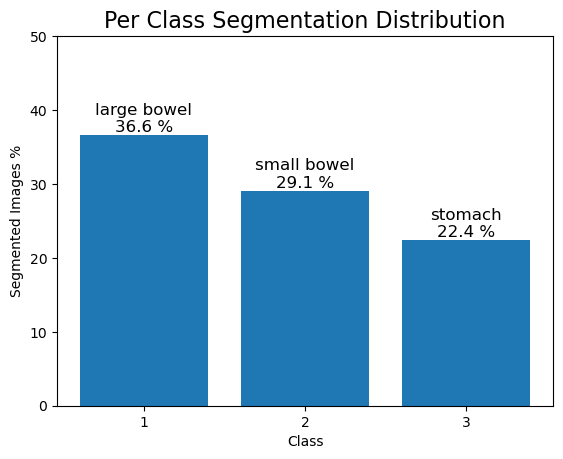

In [8]:
# plot per class segmentation distribution
def plot_segm_class(df):
    bar = plt.bar([1,2,3],100*np.mean(df.iloc[:,1:4]!='',axis=0))

    plt.title('Per Class Segmentation Distribution', fontsize=16)
    
    plt.xlabel('Class')
    plt.ylabel('Segmented Images %')
    
    plt.xticks([1,2,3])

    labels=["large bowel","small bowel","stomach"]

    for rect, lbl in zip(bar, labels):
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2, height, lbl + '\n%.1f %%' % height, ha='center', va='bottom',fontsize=12)

    plt.ylim((0,50))

    plt.show()

    
plot_segm_class(df)

**Data Statistics - Per Case Full Segmentation Distribution**

Distribuzione delle immagini totalmente segmentate per ciascun caso in esame.

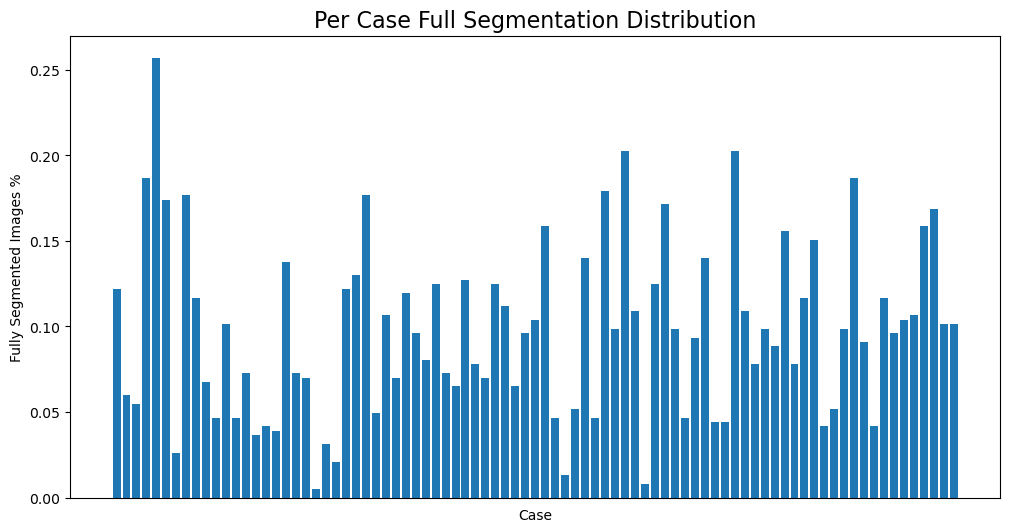

In [9]:
# plot per case full segmentation distribution 
def plot_segm_case(df):
    cases = df['case'].unique()
    n_labels = len(cases)
    
    means = np.empty(shape=n_labels)
    
    for i in range(n_labels):
        means[i] = len(df[(df['case'] == cases[i]) & (df.iloc[:,1]!='') & (df.iloc[:,2]!='') & (df.iloc[:,3]!='')])/len(df)
        
    plt.figure(figsize=(12,6))
    bar = plt.bar(np.arange(1,n_labels+1), 100*means)

    plt.title('Per Case Full Segmentation Distribution', fontsize=16)
    
    plt.ylabel('Fully Segmented Images %')
    plt.xlabel('Case')
    
    plt.xticks([])
        
    plt.show()

    
plot_segm_case(df)

**Data Statistics - Full Segmentation Distribution**

Distribuzione complessiva delle immagini totalmente segmentate.

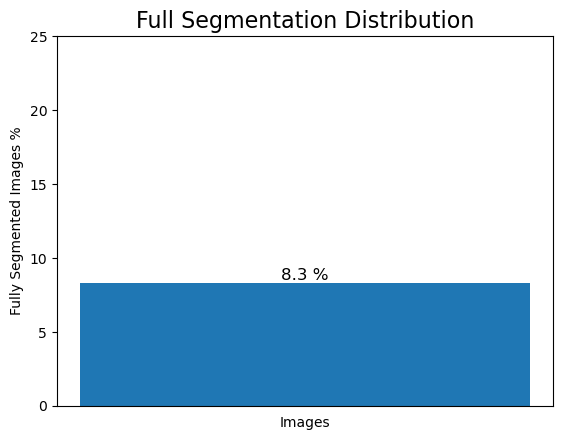

In [10]:
# plot overall full segmentation distribution 
def plot_segm(df):
    bar = plt.bar([1], 100*np.mean((df.iloc[:,1]!='') & (df.iloc[:,2]!='') & (df.iloc[:,3]!=''),axis=0))

    plt.title('Full Segmentation Distribution', fontsize=16)
    
    plt.ylabel('Fully Segmented Images %')
    plt.xlabel('Images')
    
    plt.xticks([])

    for rect in bar:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2, height, '%.1f %%' % height, ha='center', va='bottom',fontsize=12)

    plt.ylim((0,25))

    plt.show()

    
plot_segm(df)

**Data Cleaning**

Rimozione di tutti i record di dati relativi a immagini non totalmente segmentate.

In [11]:
# filter data containing NaN values and reorder indexes
def filter_data(df):
    df["large_bowel"].replace("", np.nan, inplace=True)
    df["small_bowel"].replace("", np.nan, inplace=True)
    df["stomach"].replace("", np.nan, inplace=True)
    df = df.dropna()
    df = df.reset_index(drop=True)
    return df


df = filter_data(df)

print("data_len:", len(df))
df.head()

data_len: 3201


,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height
0,case123_day20_slice_0082,17481 4 17746 7 18010 10 18275 12 18539 14 188...,22236 2 22500 6 22765 8 23030 10 23296 10 2356...,11052 8 11314 15 11578 19 11843 23 12108 26 12...,/kaggle/input/uw-madison-gi-tract-image-segmen...,123,20,0082,266,266
1,case123_day20_slice_0083,17480 6 17745 8 18010 11 18275 13 18540 15 188...,22234 6 22499 9 22764 10 23030 11 23296 11 235...,11049 11 11313 16 11577 20 11842 23 12107 26 1...,/kaggle/input/uw-madison-gi-tract-image-segmen...,123,20,0083,266,266
2,case123_day20_slice_0084,17215 4 17479 8 17745 9 18010 12 18275 14 1854...,21436 4 21701 7 21966 9 22231 11 22497 12 2276...,11045 14 11308 19 11572 23 11838 24 12103 27 1...,/kaggle/input/uw-madison-gi-tract-image-segmen...,123,20,0084,266,266
3,case123_day20_slice_0085,16950 2 17214 7 17479 10 17491 4 17744 19 1800...,21435 7 21699 10 21965 11 22230 13 22496 14 22...,11043 16 11307 20 11572 23 11837 25 12102 27 1...,/kaggle/input/uw-madison-gi-tract-image-segmen...,123,20,0085,266,266
4,case123_day20_slice_0086,16949 2 17213 8 17225 4 17478 19 17743 21 1800...,21166 6 21431 8 21660 8 21696 11 21925 10 2196...,11046 11 11307 19 11571 23 11836 25 12101 27 1...,/kaggle/input/uw-madison-gi-tract-image-segmen...,123,20,0086,266,266


**Data Saving**

Salvataggio del nuovo dataset come CSV e delle relative maschere.

In [12]:
# save decoded masks of new dataset
def save_masks(df):
    for index, row in df.iterrows():
        case = str(row["case"])
        day = str(row["day"])

        mask_lb = row["large_bowel"]
        mask_sb = row["small_bowel"]
        mask_s = row["stomach"]

        h = row["height"]
        w = row["width"]

        path = "/kaggle/working/data/processed/masks/" + case + "/" + day + "/"

        if (not os.path.exists(path)):
            os.makedirs(path)

        img_lb = np.uint8(rle_decode(mask_lb, (h,w,1)))
        img_lb = img_lb.astype(np.float32) *  255.
        cv2.imwrite(path + "large_bowel.png", img_lb)
        img_sb = np.uint8(rle_decode(mask_sb, (h,w,1)))
        img_sb = img_sb.astype(np.float32) *  255.
        cv2.imwrite(path + "small_bowel.png", img_sb)
        img_s = np.uint8(rle_decode(mask_s, (h,w,1)))
        img_s = img_s.astype(np.float32) *  255.
        cv2.imwrite(path + "stomach.png", img_s)

# save new dataset as csv
# df.to_csv("/kaggle/working/data/processed/data.csv", index=False)


# save_masks(df)

**Data Generation**

Si utilizza la classe DataGenerator di Keras per la generazione dei dati a batch che consente di risparmiare la memoria impiegata per il caricamento del dataset di immagini.

Sono stati distinti due casi di generazione dei dati: 

- default/train -> generazione di una batch (size 8) a partire da due minibatch: 
    
    - train minibatch (size 6): immagini esistenti del train set.
                         
    - augmented minibatch (size 2): immagini aumentate ottenute dalla train minibatch.
                         
        I dati generati per il training sono incrementati del 33%
        circa, ottenendo un train set complessivo con il 25% circa di immagini aumentate.
                         
- validation/test -> viene generata direttamente una batch (size 8) dal validation/test set.

In [13]:
# DataGenerator class
class DataGenerator(tf.keras.utils.Sequence):
    
    # DataGenerator initialization
    def __init__(self, df, batch_size = BATCH_SIZE, shuffle=False, subset="train"):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = (int)(batch_size)
        self.indexes = np.arange(len(df))
        self.on_epoch_end()
        
        if (self.subset == "train"):
            self.augm_minibatch_size = int(np.floor((int)(0.25 * self.batch_size)))
            self.batch_len = int(np.floor(len(self.df) / (self.batch_size - self.augm_minibatch_size)))
            self.augm_len = int(np.floor(self.augm_minibatch_size * self.batch_len))
        else:
            self.batch_len = int(np.floor(len(self.df) / (int)(self.batch_size)))
    
    # BATCH_LEN
    def __len__(self):
        return self.batch_len
            
    # epoch end event trigger
    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    # image and mask batch generation
    def __getitem__(self, index):
        
        # default/train batch case
        if (self.subset=="train"):
            
            # create minibatch with 3/4 BATCH_SIZE original samples
            X = np.empty(((self.batch_size - self.augm_minibatch_size),IM_HEIGHT,IM_WIDTH,3))
            y = np.empty((((self.batch_size - self.augm_minibatch_size),IM_HEIGHT,IM_WIDTH,3)))
            
            indexes = self.indexes[index*((self.batch_size - self.augm_minibatch_size)):(index+1)*((self.batch_size - self.augm_minibatch_size))]

            for i, img_path in enumerate(self.df['path'].iloc[indexes]):
                w=self.df['width'].iloc[indexes[i]]
                h=self.df['height'].iloc[indexes[i]]

                img = cv2.imread(img_path, cv2.IMREAD_ANYDEPTH)
                dsize = (IM_HEIGHT,IM_WIDTH)
                img = cv2.resize(img, dsize)
                img = img.astype(np.float32) / 255.
                img = np.expand_dims(img, axis=-1)

                X[i,] = img 

                for k,j in enumerate(["large_bowel","small_bowel","stomach"]):
                    rles = self.df[j].iloc[indexes[i]]
                    mask = rle_decode(rles, shape=(h, w, 1))
                    mask = cv2.resize(mask, (IM_HEIGHT,IM_WIDTH))
                    y[i,:,:,k] = mask

            # create minibatch with 1/4 BATCH_SIZE augmented samples
            X_augm, y_augm = self.augment_data(X, y)

            # concat minibatches in a batch with BATCH_SIZE samples
            X = tf.concat([X, X_augm], axis=0)
            y = tf.concat([y, y_augm], axis=0)
            
            return X, y
        
        # validation/test batch case
        else:
            
            # create batch with BATCH_SIZE original samples
            X = np.empty((self.batch_size,IM_HEIGHT,IM_WIDTH,3))
            y = np.empty((self.batch_size,IM_HEIGHT,IM_WIDTH,3))
            
            indexes = self.indexes[index*(self.batch_size):(index+1)*(self.batch_size)]
            
            for i, img_path in enumerate(self.df['path'].iloc[indexes]):
                w=self.df['width'].iloc[indexes[i]]
                h=self.df['height'].iloc[indexes[i]]

                img = cv2.imread(img_path, cv2.IMREAD_ANYDEPTH)
                dsize = (IM_HEIGHT,IM_WIDTH)
                img = cv2.resize(img, dsize)
                img = img.astype(np.float32) / 255.
                img = np.expand_dims(img, axis=-1)

                X[i,] = img 

                for k,j in enumerate(["large_bowel","small_bowel","stomach"]):
                    rles = self.df[j].iloc[indexes[i]]
                    mask = rle_decode(rles, shape=(h, w, 1))
                    mask = cv2.resize(mask, (IM_HEIGHT,IM_WIDTH))
                    y[i,:,:,k] = mask
                    
            return X, y

    
    # data augmentation
    # augmented data -> 1/3 of train existing samples
    def augment_data(self, X, y):
                
        augm_data = get_augmented(
            X, y, batch_size=self.augm_minibatch_size,
            data_gen_args = dict(
                rotation_range=180,
                width_shift_range=0.02,
                height_shift_range=0.02,
                shear_range=10,
                zoom_range=0.2,
                horizontal_flip=False,
                vertical_flip=True,
                fill_mode='constant'
            )
        )
        
        X_augm, y_augm = next(augm_data)
        
        return X_augm, y_augm

**Data Visualization**

Visualizzazione di una batch campione di immagini e relative segmentazioni.

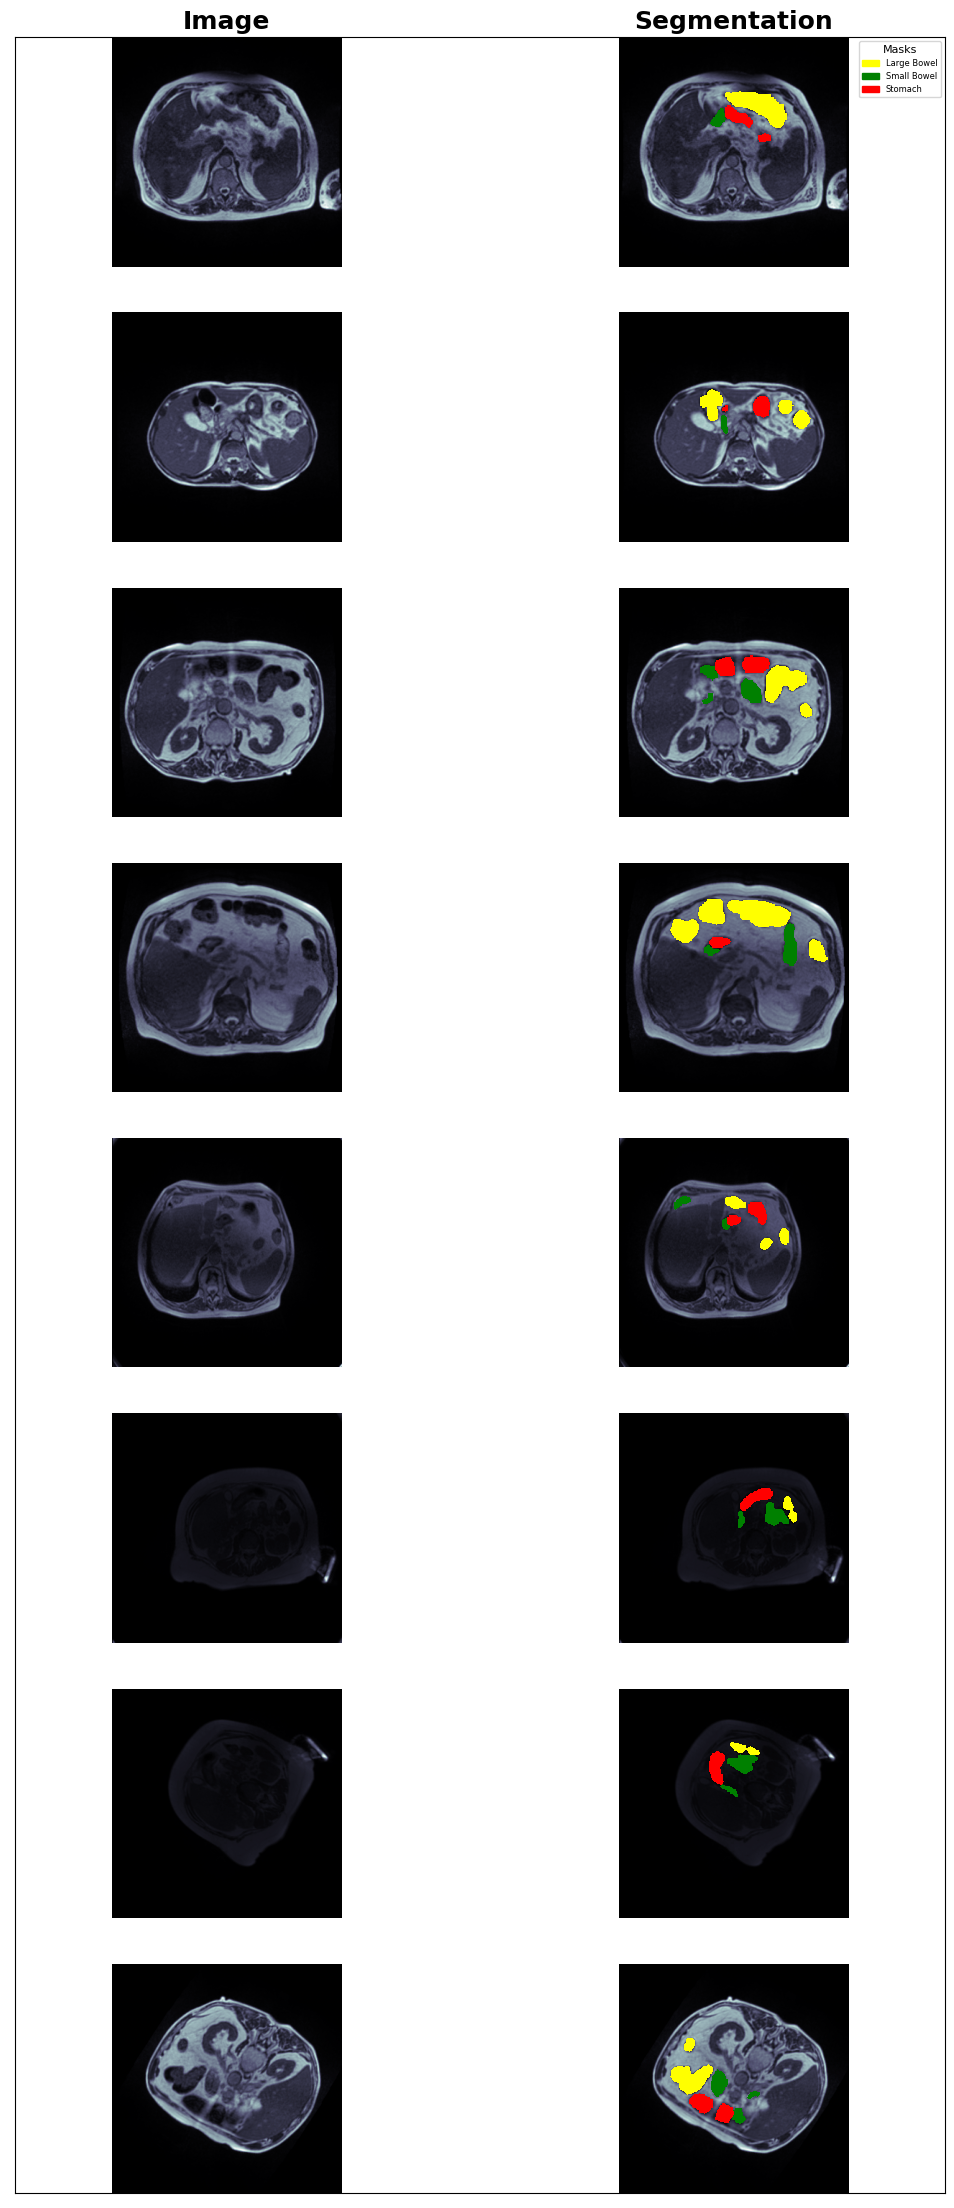

In [14]:
# sample plot
def plot_segm(img, mask):
    
    # labels
    labels = ["Large Bowel", "Small Bowel", "Stomach"]

    # label colors
    colors = ['yellow','green','red']

    # color maps
    cmap1 = mpl.colors.ListedColormap(colors[0])
    cmap2 = mpl.colors.ListedColormap(colors[1])
    cmap3= mpl.colors.ListedColormap(colors[2])

    # patches
    patches = [mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

    # grid figure
    fig = plt.figure(figsize=(12,28)) # figsize=(25,200) for batch_size = 32 
    grid = gridspec.GridSpec(nrows=BATCH_SIZE, ncols=2)
    plt.legend(handles=patches, fontsize=6, loc=1, title='Masks', title_fontsize=8)
    plt.xticks([])
    plt.yticks([])

    # plot images and segmentations
    for i in range(BATCH_SIZE):
        
        ax0 = fig.add_subplot(grid[i, 0])
        ax0.imshow(img[i,:,:,0], cmap='bone')
        
        mask_lb = mask[i,:,:,0]
        mask_sb = mask[i,:,:,1]
        mask_s = mask[i,:,:,2]

        ax1 = fig.add_subplot(grid[i, 1])
        ax1.imshow(img[i,:,:,0], cmap='bone')

        im1 = ax1.imshow(np.ma.masked_where(mask_lb == False, mask_lb), cmap=cmap1, alpha=1)
        im2 = ax1.imshow(np.ma.masked_where(mask_sb == False, mask_sb), cmap=cmap2, alpha=1)
        im3 = ax1.imshow(np.ma.masked_where(mask_s == False, mask_s), cmap=cmap3, alpha=1)
        
        for ax in [ax0,ax1]:
            ax.set_axis_off()
        
        for im in [im1,im2,im3]:
            im.cmap(im.norm(1))
        
        if (i==0):
            ax0.set_title("Image", fontsize=18, weight='bold')
            ax1.set_title("Segmentation", fontsize=18, weight='bold')

# data generator instance
data_gen = DataGenerator(df, shuffle=True)

# get batch sample
img, mask = data_gen[0]


plot_segm(img, mask)

**Data Splitting**

Considerando il dataset ottenuto dopo la fase di cleaning, si è scelto di utilizzare uno split **80% train, 10% validation, 10% test**.

(Si esclude in questa fase la generazione di augmented data per il train set)

In [15]:
df_train = df.sample(frac=0.8, random_state=0)
df_val_test = df.drop(df_train.index)
df_val = df_val_test.sample(frac=0.5, random_state=0)
df_test = df_val_test.drop(df_val.index)

print("train_len:", len(df_train))
print("validation_len:", len(df_val))
print("test_len:", len(df_test))

train_len: 2561
validation_len: 320
test_len: 320


# **Model Selection**

**Metrics**

Si sono selezionate due metriche di similarità per la valutazione dell'accuratezza del modello: 

- coefficiente di **Dice** -> 2 |A∩B| / (|A|+|B|)
       
   Tende a indicare l'accuratezza di segmentazione nel caso medio.
                               
- coefficiente di Intersection over Union (**IoU**) -> |A∩B| / |A∪B|
    
   Tende a indicare l'accuratezza di segmentazione nel caso peggiore.

In [16]:
# Dice coefficent
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Intersection over Union (IoU) coefficent
def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    return K.mean((intersection + smooth) / (union + smooth), axis=0)

**Loss**

Si è selezionata una funzione di loss che è combinazione della Binary Cross Entropy (BCE) loss e della Dice loss: 

- BCE loss -> similarità di informazione tra le distribuzioni di probabilità dei due set.

- Dice loss -> similarità bit a bit tra i due set.
    
    **BCE Dice loss** -> BCE loss + Dice loss
        
N.B. La metrica IoU non è utilizzabile per la funzione di loss in quanto non differenziabile.

In [17]:
# Dice loss
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

# Binary cross-entropy (BCE) dice loss
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + dice_loss(tf.cast(y_true, tf.float32), y_pred)

**Definition**

Si è selezionato **U-Net** come modello di deep learning per le sue performance nel campo della segmentazione di immagini mediche. 

Per l'encoder di U-Net si sono confrontati due architetture di rete neurale convoluzionale (CNN) preaddestrate su ImageNet: 

- VGG16: CNN con 13 layers convoluzionali e 3 layers fully connected.
    
- ResNet34: CNN residuale con 33 layers convoluzionali e 1 layer fully connected.

    **ResNet34** ha ottenuto performance lievemente superiori ed è stata quindi selezionata.
    
    Nella directory "kaggle/working/models" sono presenti entrambe le versioni addestrate con relativa learning history.

Segmentazione multiclasse -> Output con tre mappe di probabilità di segmentazione dei pixel.

Metriche -> coefficienti di Dice e IoU.

Loss -> BCE Dice loss.

Ottimizzatore -> Algoritmo adattivo Adam con learning rate iniziale di 10^-4.

In [18]:
# enable multiple GPUs use
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    
    """""""""
    # *** U-Net_vgg16 ***
    # define multiclass U-Net model with VGG16 as backbone
    model = Unet(
        backbone_name='vgg16', 
        input_shape=(IM_HEIGHT, IM_WIDTH, 3), 
        classes=3, 
        activation='sigmoid', 
        encoder_weights='imagenet')
    """""""""
    
    # *** U-Net_resnet34 ***
    # define multiclass U-Net model with ResNet34 as backbone
    model = Unet(
        backbone_name='resnet34',
        input_shape=(IM_HEIGHT, IM_WIDTH, 3), 
        classes=3, 
        activation='sigmoid', 
        encoder_weights='imagenet')
    
    # define custom optimizer, metrics and loss
    optimizer = Adam(LR)
    model.compile(
        optimizer=optimizer, 
        metrics=[dice_coef,iou_coef], 
        loss=bce_dice_loss)
    
# show model info
model.summary()

85521592/85521592 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 320, 320, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 326, 326, 3)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)            

**K-Fold Cross-validation**

Valutazione del modello mediante K-Fold Cross-validation con 10 splits.

(Non è stato possibile eseguire per mancanza di risorse)

In [19]:
"""""""""
# 10 splits
cv = KFold(n_splits=N_SPLITS)

# model, loss, dice and iou arrays
models = np.empty(shape=N_SPLITS)
val_losses = np.empty(shape=N_SPLITS)
val_dice_coefs = np.empty(shape=N_SPLITS)
val_iou_coefs = np.empty(shape=N_SPLITS)

for i, (train_ids, val_ids) in enumerate (cv.split(df_train)):
    # create train and validation folds
    df_train_fold = df_train.filter(items = train_ids, axis=0)
    df_val_fold = df_train.filter(items = val_ids, axis=0)
    
    # train and validation generators instance
    train_gen = DataGenerator(df_train_fold, shuffle=True)
    val_gen = DataGenerator(df_val_fold, shuffle=True, subset="val")
    
    models[i] = model
    
    # fit model
    models[i].fit(
        x=train_gen,
        validation_data=val_gen,
        epochs=EPOCHS)
    
    # evaluate model on validation set
    scores = model[i].evaluate(x=val_gen)
    
    # read loss, dice and iou
    val_losses.append(scores['val_loss'])
    val_dice_coefs.append(scores['val_dice_coef'])
    val_iou_coefs.append(scores['val_iou_coef'])

# compute loss, dice and iou means as cross-validation scores
cv_loss = np.mean(val_losses)
cv_dice_coef = np.mean(val_dice_coefs)
cv_iou_coef = np.mean(val_iou_coefs)

print("val_dice scores: ", val_dice_coefs)
print("val_iou scores: ", val_iou_coefs)
print("val_loss scores: ", val_losses)

print("cv_dice_coef score: ", cv_dice_coef)
print("cv_iou_coef score: ", cv_iou_coef)
print("cv_loss score: ", cv_loss)
"""""""""

print("Not enough resources to run cross-validation...")

Not enough resources to run cross-validation...


# **Model Training**

**Callbacks**

Utilizzo delle seguenti callbacks per il fitting del modello:

- **ModelCheckpoint**: salvataggio del modello migliore secondo un certo score.
    
- **ReduceLROnPlateau**: decay del learning rate se il modello non migliora secondo un certo score dopo un numero prefissato di epoche.
    
    Per entrambe le callbacks lo score scelto da monitorare è la validation loss.

In [20]:
# ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    filepath="/kaggle/working/models/U-Net_resnet34/model.h5",
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min'
)

# ReduceLROnPlateau callback
reduce_lr_on_plateau = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10, # 5
    verbose=1,
    min_delta=0.0001
)

**Fitting**

Fitting del modello su 100 epoche.

In [21]:
"""""""""
# train and validation data generators instance
train_gen = DataGenerator(df_train, shuffle=True, subset="train")
val_gen = DataGenerator(df_val, shuffle=True, subset="validation")

# garbage collection 
gc.collect()

# fit model
fit_result = model.fit(
    x=train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[reduce_lr_on_plateau, model_checkpoint])
"""""""""

# load pretrained model
model = load_model(
     filepath="/kaggle/working/models/U-Net_resnet34/model.h5", # ".../U-Net_vgg16/model.h5"
     custom_objects={'dice_coef':dice_coef,'iou_coef':iou_coef,'bce_dice_loss':bce_dice_loss})

**Learning Curves**

Curve di apprendimento per train e validation rispetto alla loss e alle metriche.

Epoche trascorse per il raggiungimento del modello migliore e relativi scores.

MODEL CHECKPOINT EPOCHS: 74

TRAIN SCORES
train_loss: 0.0472
train_dice_coef: 0.9571
train_iou_coef: 0.9147

VALIDATION SCORES
val_loss: 0.0929
val_dice_coef: 0.9203
val_iou_coef: 0.8490



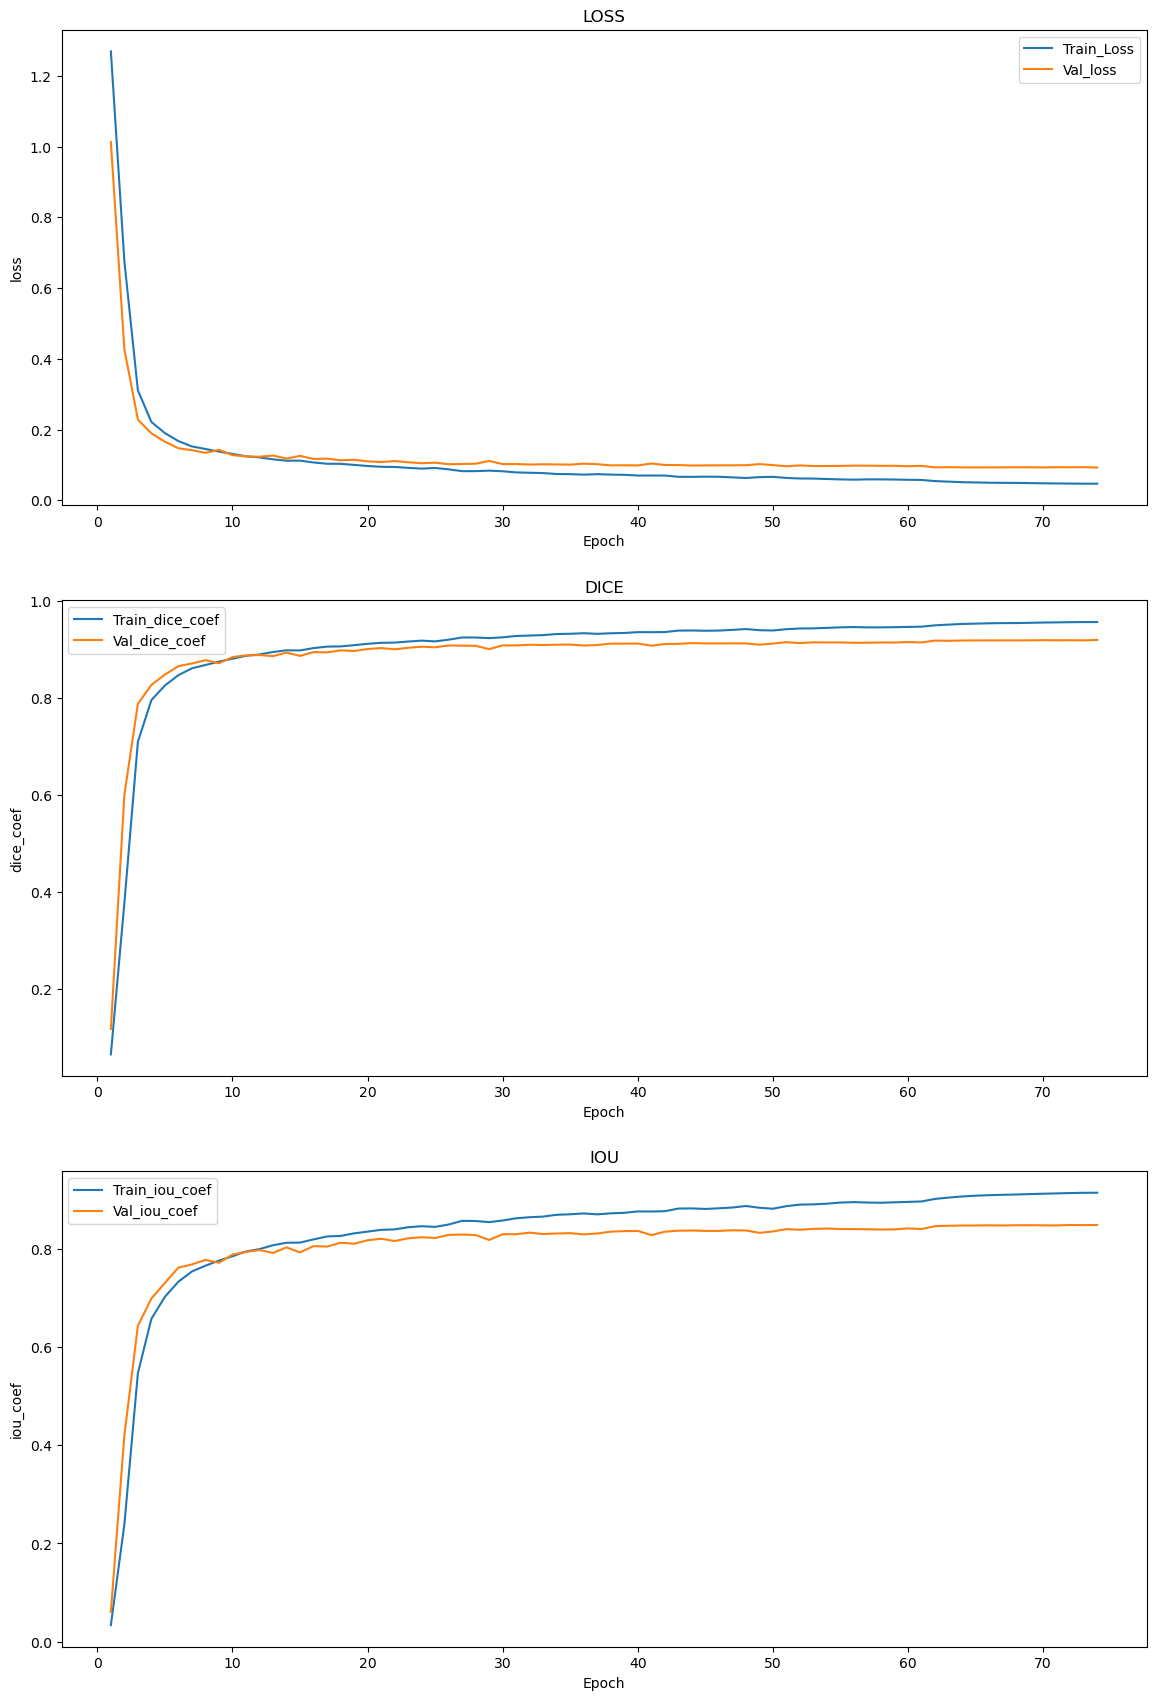

In [22]:
# plot learning curves
def learning_plot(history, epochs):
    
    plt.figure(figsize=(14,21))
    
    # train/validation loss subplot
    plt.subplot(3,1,1)
    plt.plot(range(1,epochs+1),history['loss'][0:epochs],label='Train_Loss')
    plt.plot(range(1,epochs+1),history['val_loss'][0:epochs],label='Val_loss')
    plt.title('LOSS')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend()

    # train/validation dice subplot
    plt.subplot(3,1,2)
    plt.plot(range(1,epochs+1),history['dice_coef'][0:epochs],label='Train_dice_coef')
    plt.plot(range(1,epochs+1),history['val_dice_coef'][0:epochs],label='Val_dice_coef')
    plt.title('DICE')
    plt.xlabel('Epoch') 
    plt.ylabel('dice_coef')
    plt.legend()

    # train/validation iou subplot
    plt.subplot(3,1,3)
    plt.plot(range(1,epochs+1),history['iou_coef'][0:epochs],label='Train_iou_coef')
    plt.plot(range(1,epochs+1),history['val_iou_coef'][0:epochs],label='Val_iou_coef')
    plt.title('IOU')
    plt.xlabel('Epoch')
    plt.ylabel('iou_coef')
    plt.legend()

    plt.show()

"""""""""
# history dataframe
history_df = pd.DataFrame(fit_result.history)

# save history dataframe as csv
history_df.to_csv("/kaggle/working/models/U-Net_resnet34/history.csv") # ".../U-Net_vgg16/history.csv"
"""""""""

# load history csv as dataframe
history_df = pd.read_csv("/kaggle/working/models/U-Net_resnet34/history.csv") # ".../U-Net_vgg16/history.csv"

# MODEL CHECKPOINT EPOCHS
mcp_epochs = history_df["val_loss"].idxmin() + 1
print("MODEL CHECKPOINT EPOCHS:", mcp_epochs)

print()

# *** TRAIN SCORES ***
print("TRAIN SCORES")
print("train_loss: %.4f" % history_df["loss"][mcp_epochs-1])
print("train_dice_coef: %.4f" % history_df["dice_coef"][mcp_epochs-1])
print("train_iou_coef: %.4f" % history_df["iou_coef"][mcp_epochs])

print()

# *** VALIDATION SCORES ***
print("VALIDATION SCORES")
print("val_loss: %.4f" % history_df["val_loss"][mcp_epochs-1])
print("val_dice_coef: %.4f" % history_df["val_dice_coef"][mcp_epochs-1])
print("val_iou_coef: %.4f" % history_df["val_iou_coef"][mcp_epochs-1])

print()


learning_plot(history_df, mcp_epochs)

# **Model Testing**

**Prediction**

Calcolo predizioni sul test set e conversione delle mappe di probabilità a immagini binarie. 

Visualizzazione di una batch campione di ground truth e di predizione delle segmentazioni. 

40/40 [==============================] - 13s 110ms/step


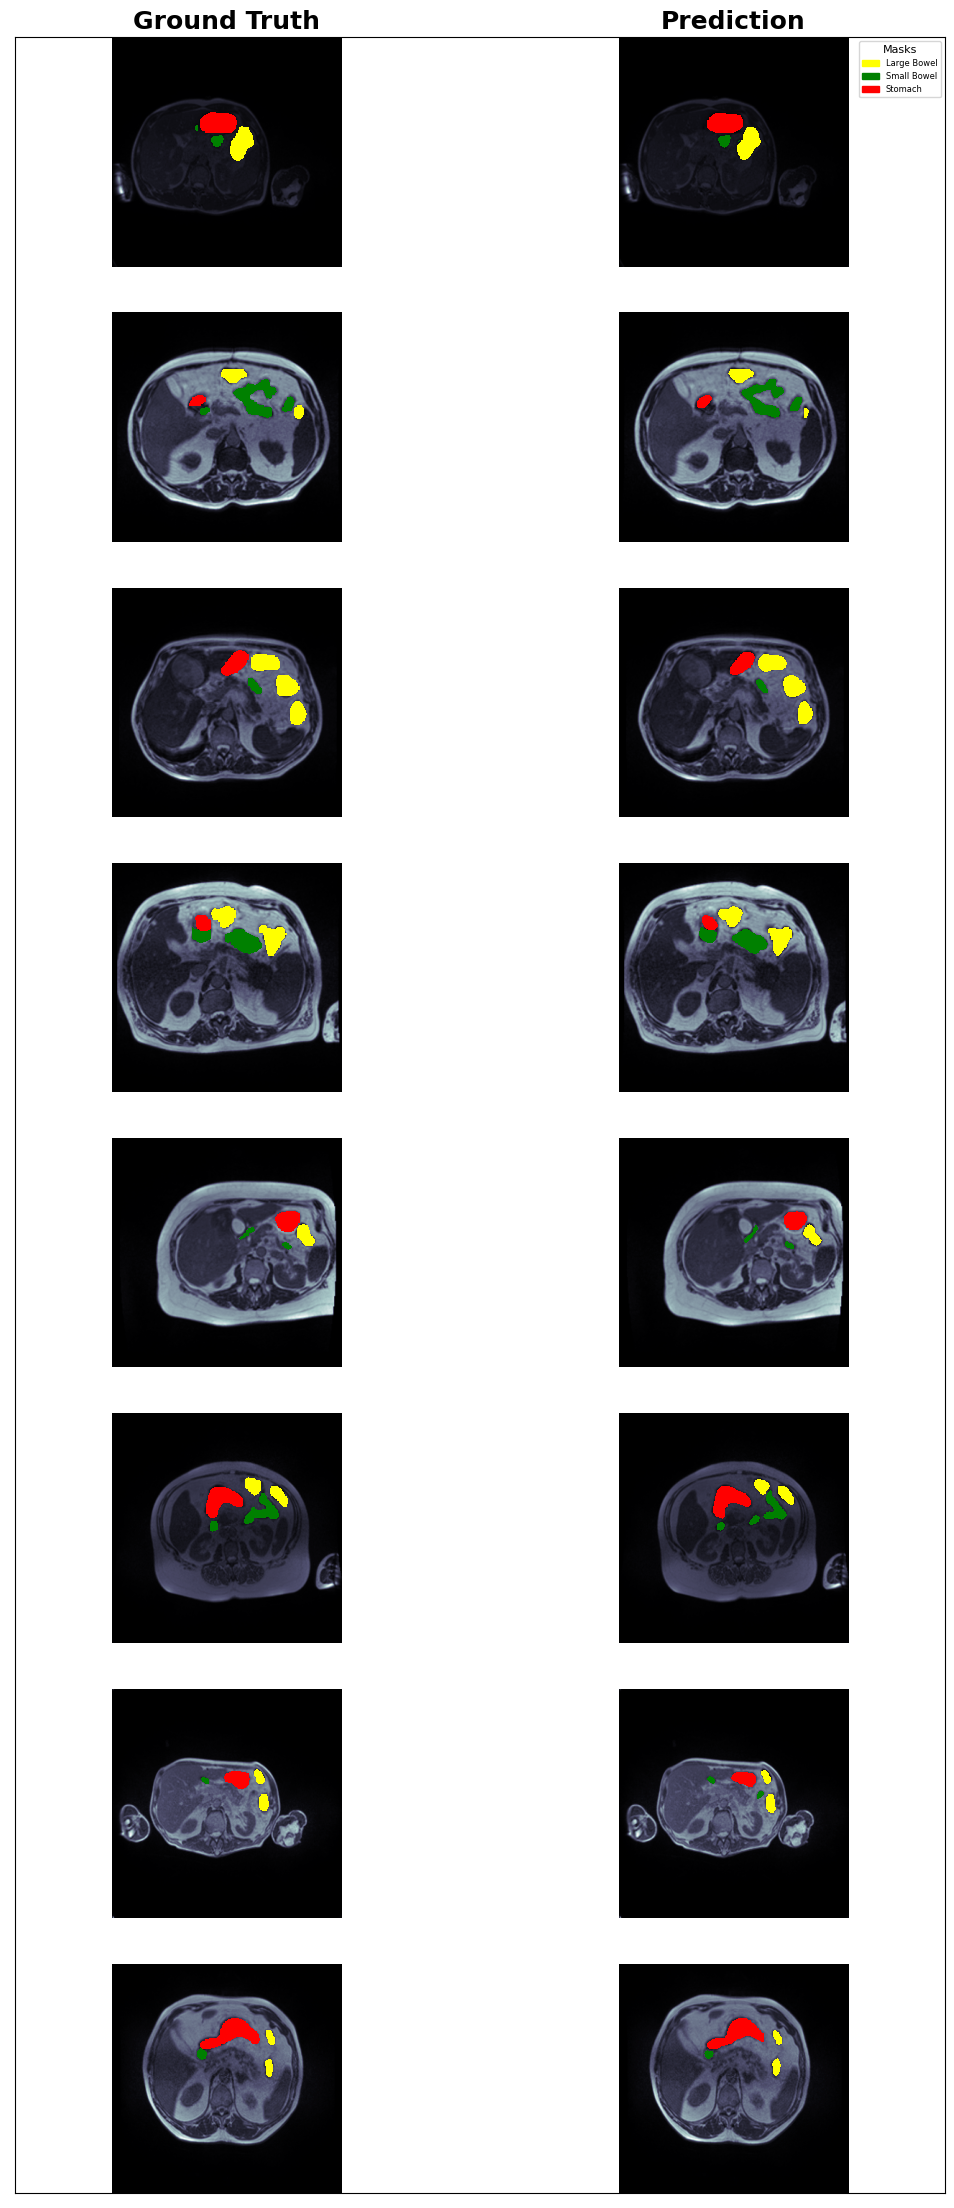

In [23]:
# prediction plot
def plot_pred_segm(img, mask, pred):
    
    # labels
    labels = ["Large Bowel", "Small Bowel", "Stomach"]

    # label colors
    colors = ['yellow','green','red']

    # color maps
    cmap1 = mpl.colors.ListedColormap(colors[0])
    cmap2 = mpl.colors.ListedColormap(colors[1])
    cmap3= mpl.colors.ListedColormap(colors[2])

    # patches
    patches = [mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

    # grid figure
    fig = plt.figure(figsize=(12,28))
    grid = gridspec.GridSpec(nrows=BATCH_SIZE, ncols=2)
    plt.legend(handles=patches, fontsize=6, loc=1, title='Masks', title_fontsize=8)
    plt.xticks([])
    plt.yticks([])

    # plot ground truth and predicted segmentations
    for i in range(BATCH_SIZE):
        
        mask_lb = mask[i,:,:,0]
        mask_sb = mask[i,:,:,1]
        mask_s = mask[i,:,:,2]

        ax0 = fig.add_subplot(grid[i, 0])
        ax0.imshow(img[i,:,:,0], cmap='bone')

        im1 = ax0.imshow(np.ma.masked_where(mask_lb == False, mask_lb), cmap=cmap1, alpha=1)
        im2 = ax0.imshow(np.ma.masked_where(mask_sb == False, mask_sb), cmap=cmap2, alpha=1)
        im3 = ax0.imshow(np.ma.masked_where(mask_s == False, mask_s), cmap=cmap3, alpha=1)
            
        pred_lb = pred[i,:,:,0]
        pred_sb = pred[i,:,:,1]
        pred_s = pred[i,:,:,2]

        ax1 = fig.add_subplot(grid[i, 1])
        ax1.imshow(img[i,:,:,0], cmap='bone')
        
        im4 = ax1.imshow(np.ma.masked_where(pred_lb == False, pred_lb), cmap=cmap1, alpha=1)
        im5 = ax1.imshow(np.ma.masked_where(pred_sb == False, pred_sb), cmap=cmap2, alpha=1)
        im6 = ax1.imshow(np.ma.masked_where(pred_s == False, pred_s), cmap=cmap3, alpha=1)
        
        for ax in [ax0,ax1]:
            ax.set_axis_off()
        
        for im in [im1,im2,im3,im4,im5,im6]:
            im.cmap(im.norm(1))
            
        if (i==0):
            ax0.set_title("Ground Truth", fontsize=18, weight='bold')
            ax1.set_title("Prediction", fontsize=18, weight='bold')
            
# test data generator instance 
test_gen = DataGenerator(df_test, shuffle=True, subset="test")

# get test batch sample
img, mask = test_gen[0]

# predict on test set
preds = model.predict(x=test_gen, verbose=1)

# convert pixel probability maps to binary image
preds = (preds > 0.5).astype(np.float32)

# prediction batch sample
pred = preds[0:BATCH_SIZE]


plot_pred_segm(img, mask, pred)

**Performance**

Test scores per la valutazione delle performance del modello.

In [26]:
# evaluate model on test set
eval_result = model.evaluate(x=test_gen,verbose=1)

# *** TEST SCORES ***
print("TEST SCORES")
print("test_loss: %.4f" % eval_result[0])
print("test_dice_coef: %.4f" % eval_result[1])
print("test_iou_coef: %.4f" % eval_result[2])

40/40 [==============================] - 4s 105ms/step - loss: 0.0949 - dice_coef: 0.9190 - iou_coef: 0.8454
TEST SCORES
test_loss: 0.0949
test_dice_coef: 0.9190
test_iou_coef: 0.8454


**Submission**

Sottomissione del CSV contenente le predizioni calcolate sul test set.

In [25]:
# create, fill and save submission with predictions 
def pred_submit(ids, preds):

    # load submission template csv as dataframe
    submission_df = pd.read_csv("/kaggle/input/uw-madison-gi-tract-image-segmentation/sample_submission.csv")

    # split predictions per classes
    preds_lb = preds[:,:,:,0]
    preds_sb = preds[:,:,:,1]
    preds_s = preds[:,:,:,2]

    for i in range(len(preds)):

        # create rows
        row_lb = [ids.iloc[i], 'large_bowel', rle_encode(preds_lb[i])]
        row_sb = [ids.iloc[i], 'small_bowel', rle_encode(preds_sb[i])]
        row_s = [ids.iloc[i], 'stomach', rle_encode(preds_s[i])]

        # append rows to dataframe
        submission_df.loc[len(submission_df)] = row_lb
        submission_df.loc[len(submission_df)] = row_sb
        submission_df.loc[len(submission_df)] = row_s
    
    # save dataframe as csv
    submission_df.to_csv("/kaggle/working/sample_submission.csv")
    
    
# pred_submit(df_test['id'], preds)

# load submission csv as dataframe
submission_df = pd.read_csv("/kaggle/working/sample_submission.csv")

print("submission_len:", len(submission_df))
submission_df[['id','class','predicted']].head()

submission_len: 960


,id,class,predicted
0,case123_day20_slice_0089,large_bowel,39860 7 40178 12 40497 15 40817 16 41136 17 41...
1,case123_day20_slice_0089,small_bowel,43668 8 43981 16 44299 19 44619 19 44938 20 45...
2,case123_day20_slice_0089,stomach,33733 18 34051 35 34370 39 34689 42 35008 44 3...
3,case133_day23_slice_0072,large_bowel,25117 20 25435 29 25754 32 26073 35 26393 36 2...
4,case133_day23_slice_0072,small_bowel,29651 8 29969 11 30288 12 30607 14 30926 15 31...
